In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [19]:
df = pd.read_json('Cell_Phones_and_Accessories_5.json', lines=True)

In [20]:
#eliminando reviews nulas
df.dropna()
#eliminando reviews de espacos vazios
df = df.drop(df[df['reviewText'].str.isspace()].index)

In [21]:
df.columns
df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime'], axis='columns', inplace=True)

In [23]:
df['overall'].value_counts()

overall
5    108664
4     39993
3     21439
1     13279
2     11064
Name: count, dtype: int64

In [133]:
import re
import nltk 
import warnings
from string import punctuation
import tensorflow as tf 
from tensorflow import keras 
from nltk.stem import WordNetLemmatizer 
warnings.filterwarnings('ignore')
lemma = WordNetLemmatizer()

In [134]:
def DataPrep(text) : 
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    
    # tokenization 
    tokens = nltk.word_tokenize(text) 
    
    # remove puncs 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    
    
    # lemmatization 
    words = [lemma.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    return text

In [110]:
nltk.download('punkt')
nltk.download('wordnet')
df['reviewText'] = df['reviewText'].apply(DataPrep)

[nltk_data] Downloading package punkt to /home/joaovitor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/joaovitor/nltk_data...


In [112]:
X = df['reviewText']
y = df['overall']

In [113]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size= 0.3, random_state= 101)

In [114]:

count_vect = CountVectorizer(stop_words='english')

sparcity_matrix = count_vect.fit_transform(df['reviewText'])
words_freq = zip(count_vect.get_feature_names_out(), sparcity_matrix.sum(axis=0).tolist()[0])

In [115]:
top_ten_words = (sorted(words_freq, key=lambda x: -x[1]))[:10]

In [116]:
dic_words = dict(top_ten_words)
dic_words

{'phone': 191091,
 'case': 163628,
 'wa': 108316,
 'like': 74421,
 'great': 66707,
 'battery': 65006,
 'screen': 62251,
 'use': 61621,
 'just': 61213,
 'good': 58494}

Text(0.5, 1.0, 'Words that appeared most')

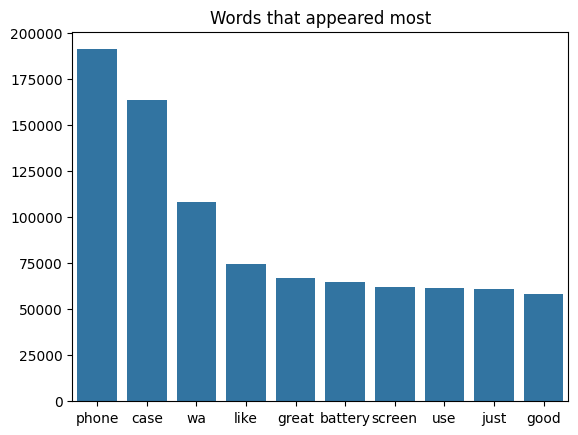

In [117]:
ax = sns.barplot(x = dic_words.keys(), y = dic_words.values())
ax.set_title('Words that appeared most')

In [118]:
tfidf = TfidfVectorizer(stop_words='english')

In [119]:
tfidf.fit(X_train)

TfidfVectorizer(stop_words='english')

In [120]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [121]:
X_train_tfidf

<58331x81085 sparse matrix of type '<class 'numpy.float64'>'
	with 1878202 stored elements in Compressed Sparse Row format>

In [122]:
log_model = LogisticRegression(max_iter=5000)
log_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=5000)

In [123]:
model_predictions_log = log_model.predict(X_test_tfidf)
print(classification_report(y_test, model_predictions_log))

              precision    recall  f1-score   support

           1       0.58      0.48      0.52      9369
           2       0.30      0.07      0.11      7814
           3       0.38      0.24      0.29     14939
           4       0.42      0.25      0.32     28131
           5       0.69      0.92      0.79     75855

    accuracy                           0.63    136108
   macro avg       0.48      0.39      0.41    136108
weighted avg       0.57      0.63      0.58    136108



In [124]:
#Modelo usando SVM

from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train_tfidf,y_train)

LinearSVC()

In [125]:
model_predictions_svc = svc.predict(X_test_tfidf)
print(classification_report(y_test, model_predictions_svc))

              precision    recall  f1-score   support

           1       0.53      0.49      0.51      9369
           2       0.25      0.08      0.12      7814
           3       0.36      0.23      0.28     14939
           4       0.38      0.25      0.30     28131
           5       0.70      0.90      0.79     75855

    accuracy                           0.61    136108
   macro avg       0.44      0.39      0.40    136108
weighted avg       0.56      0.61      0.57    136108



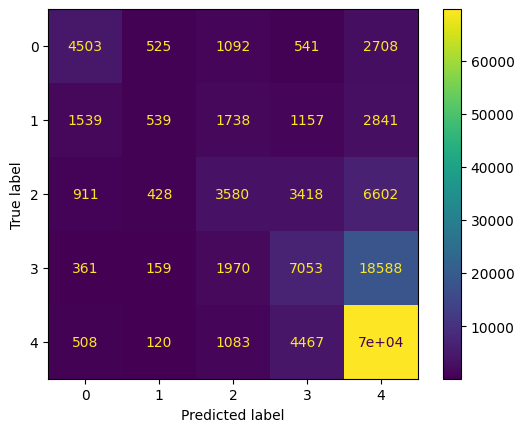

In [126]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, model_predictions_log))
disp.plot()
plt.show()

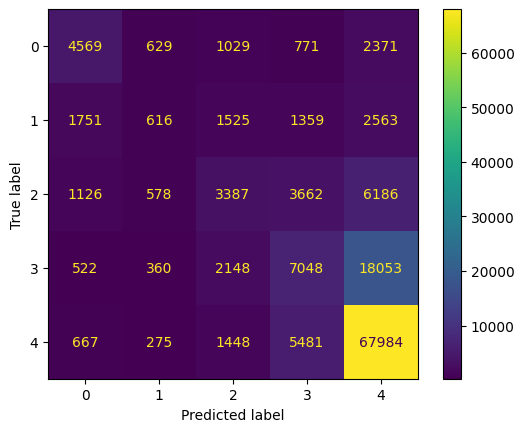

In [127]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, model_predictions_svc))
disp.plot()
plt.show()

In [128]:
#Criando pipeline para novas entradas
pipe = Pipeline([('tfidf',TfidfVectorizer()),('svc',LinearSVC())])

In [129]:
pipe.fit(df['reviewText'], df['overall'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc', LinearSVC())])

In [130]:
new_review = ['i hate this app']
pipe.predict(new_review)

array([1])

In [131]:
new_review = ['this app is ok']
pipe.predict(new_review)

array([3])

In [132]:
new_review = ['this app is amazing']
pipe.predict(new_review)

array([5])